In [35]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

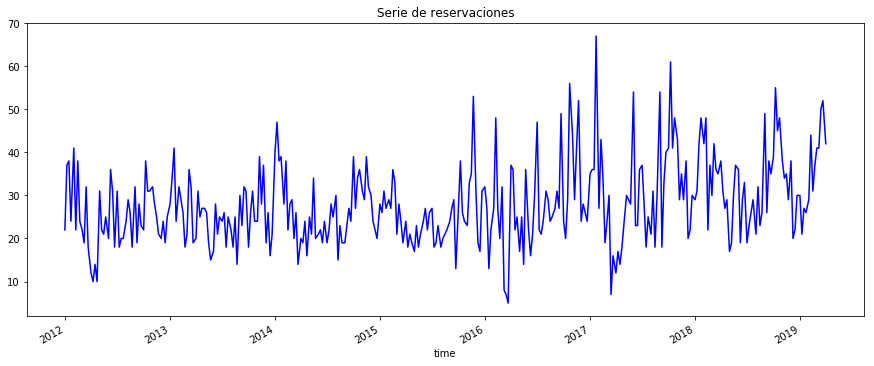

In [36]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('./data/hotelguests.csv', parse_dates=['time'], index_col='time',date_parser=dateparse)
ts = data['#guests']
ts.plot(c='b', title='Serie de reservaciones')
plt.show()

In [37]:
TS = np.array(ts)
num_periods = 12
f_horizon = 1
x_data = TS[:(len(TS)-(len(TS)% num_periods))]
x_batches = x_data.reshape(-1, 12, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods)) + f_horizon]
y_batches = y_data.reshape(-1, 12, 1)

print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:2])

print(y_batches[0:1])
print(y_batches.shape)

29
(29, 12, 1)
[[[22]
  [37]
  [38]
  [24]
  [41]
  [22]
  [38]
  [24]
  [22]
  [19]
  [32]
  [18]]

 [[12]
  [10]
  [14]
  [10]
  [31]
  [22]
  [21]
  [25]
  [20]
  [36]
  [31]
  [18]]]
[[[37]
  [38]
  [24]
  [41]
  [22]
  [38]
  [24]
  [22]
  [19]
  [32]
  [18]
  [12]]]
(29, 12, 1)


In [38]:
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 12, 1)
    testY = TS[-(num_periods):].reshape(-1, 12, 1)
    return testX,testY
X_test, Y_test = test_data(TS, f_horizon, num_periods)
print(X_test.shape)
print(X_test)

(1, 12, 1)
[[[30]
  [21]
  [27]
  [26]
  [29]
  [44]
  [31]
  [37]
  [41]
  [41]
  [50]
  [52]]]


In [39]:
tf.reset_default_graph()

num_periods = 12
inputs = 1
hidden = 200
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
#BasicRNNCell
#BasicLSTMCell
learning_rate = 0.001

stacked_rnn_output = tf.reshape(rnn_output,[-1,hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_sum(tf.square(outputs - y ))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()


In [40]:
epochs = 5000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 284439.5
100 	MSE: 33481.688
200 	MSE: 20621.594
300 	MSE: 10379.572
400 	MSE: 8073.5435
500 	MSE: 10172.622
600 	MSE: 6766.1304
700 	MSE: 6266.905
800 	MSE: 6983.1196
900 	MSE: 5707.3276
1000 	MSE: 5302.933
1100 	MSE: 5054.4375
1200 	MSE: 4695.591
1300 	MSE: 4529.997
1400 	MSE: 4275.4087
1500 	MSE: 4074.2856
1600 	MSE: 3835.3198
1700 	MSE: 3705.1768
1800 	MSE: 3737.6924
1900 	MSE: 3656.6543
2000 	MSE: 3624.4248
2100 	MSE: 3603.1357
2200 	MSE: 3590.082
2300 	MSE: 3574.4697
2400 	MSE: 3564.6616
2500 	MSE: 3553.495
2600 	MSE: 3544.6504
2700 	MSE: 3544.2944
2800 	MSE: 3531.6619
2900 	MSE: 3525.1646
3000 	MSE: 3517.8975
3100 	MSE: 3522.3596
3200 	MSE: 3516.6204
3300 	MSE: 3501.1545
3400 	MSE: 3491.8577
3500 	MSE: 3483.1768
3600 	MSE: 3476.8137
3700 	MSE: 3466.0845
3800 	MSE: 3450.8518
3900 	MSE: 3441.1792
4000 	MSE: 3417.2695
4100 	MSE: 3394.6187
4200 	MSE: 3380.442
4300 	MSE: 3365.8262
4400 	MSE: 3293.0144
4500 	MSE: 3240.2908
4600 	MSE: 3208.936
4700 	MSE: 3169.187
4800 	MSE: 312

In [41]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100, np.mean(np.abs((y_true - y_pred) / y_true))

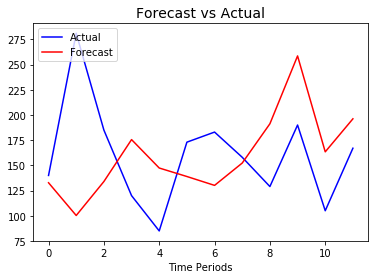

TEST
[[[140]
  [281]
  [185]
  [120]
  [ 85]
  [173]
  [183]
  [158]
  [129]
  [190]
  [105]
  [167]]]
PRED
[[[132.76048]
  [100.29158]
  [133.9637 ]
  [175.55003]
  [147.37291]
  [138.9484 ]
  [130.1511 ]
  [152.30658]
  [191.2344 ]
  [258.51694]
  [163.40344]
  [196.15213]]]


In [22]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'b', markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred)), 'r', markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()
print('TEST')
print(Y_test)
print('PRED')
print(y_pred)

In [23]:
MAPE, MAD = mean_absolute_percentage_error(Y_test,y_pred)
print("MAPE : {}".format(MAPE))
print("MAD : {}".format(MAD))

MAPE : 35.52404117422885
MAD : 0.3552404117422885
